In [1]:
# %% [markdown]
# # 🌳 Эксперименты с деревом управлений
# 
# Этот notebook для интерактивных экспериментов с `ControlTreeBuilder`.
# 
# **Файл:** `spores/v14_back/notebooks/control_tree_experiments.ipynb`

# %% [markdown]
# ## 1. Импорты и настройка

# %%
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, HTML

In [2]:
current_dir = os.getcwd()
# Поднимаемся от текущей директории до spores/v14_back/src
project_root = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'src'))
if project_root not in sys.path:
    sys.path.append(project_root)

from logic.pendulum import PendulumSystem
from logic.control_tree import ControlTreeBuilder

# Настройка matplotlib для Jupyter
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['figure.dpi'] = 100

print("✅ Модули загружены")

# %% [markdown]
# ## 2. Вспомогательные функции визуализации


✅ Модули загружены


In [3]:
def plot_dt_sensitivity(pendulum, initial_pos, dt_variations):
    """Анализ чувствительности к изменению dt."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, dt_scale in enumerate(dt_variations):
        if i >= 6:
            break
            
        # Создаем dt_vector с масштабированием
        dt_vector = np.ones(8) * 0.1 * dt_scale
        
        # Строим дерево
        builder = ControlTreeBuilder(pendulum, dt_vector)
        tree_data = builder.build_tree(initial_pos)
        
        # Визуализируем
        plot_phase_space(tree_data, axes[i])
        axes[i].set_title(f'dt scale = {dt_scale:.2f}', fontsize=10)
    
    plt.suptitle('Sensitivity to dt variations', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [4]:
# %%
def plot_phase_space(tree_data, ax=None):
    """Рисует траектории в фазовом пространстве."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    nodes = tree_data['nodes']
    edges = tree_data['edges']
    
    # Настройка осей
    ax.set_xlabel('θ (angle)', fontsize=12)
    ax.set_ylabel('θ̇ (angular velocity)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_title('Phase Space Trajectories', fontsize=14, fontweight='bold')
    
    # Рисуем траектории
    for edge in edges:
        parent = nodes[edge.parent_id]
        child = nodes[edge.child_id]
        
        # Цвет зависит от направления времени
        color = 'red' if edge.is_forward else 'blue'
        alpha = 0.7 if parent.level == 0 else 0.5
        
        ax.arrow(parent.position_2d[0], parent.position_2d[1],
                child.position_2d[0] - parent.position_2d[0],
                child.position_2d[1] - parent.position_2d[1],
                head_width=0.000001, head_length=0.00001,
                width=0.0000001,
                fc=color, ec=color, alpha=alpha,
                length_includes_head=True)
    
    # Отмечаем узлы
    for level in [0, 1, 2]:
        level_nodes = [n for n in nodes.values() if n.level == level]
        if level_nodes:
            positions = np.array([n.position_2d for n in level_nodes])
            size = 200 - level * 50
            ax.scatter(positions[:, 0], positions[:, 1],
                      s=size, alpha=0.8, 
                      edgecolors='black', linewidth=1,
                      label=f'Level {level}', zorder=3)
    
    
    ax.legend()
    return ax


In [5]:
def create_graph_from_tree_data(tree_data):
    """Создает networkx.Graph из tree_data."""
    G = nx.DiGraph()  # Используем DiGraph для направленного графа
    
    # Добавляем узлы
    for node_id, node in tree_data['nodes'].items():
        G.add_node(node_id, pos=node.position_2d, level=node.level)
    
    # Добавляем рёбра
    for edge in tree_data['edges']:
        G.add_edge(edge.parent_id, edge.child_id, 
                  control=edge.control, 
                  dt=edge.dt, 
                  is_forward=edge.is_forward)
    
    return G


In [6]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

print(f"📐 Система маятника:")
print(f"   Управление: [{-pendulum.max_control:.1f}, {pendulum.max_control:.1f}]")
print(f"   Демпфирование: {pendulum.damping}")

# %%
# Базовое дерево с одинаковыми dt
builder = ControlTreeBuilder(pendulum, dt_vector=np.ones(8) * 0.1)
initial_position = np.array([0.0+np.pi, 0.0])

print(f"🌱 Начальная позиция: θ={initial_position[0]:.2f}, θ̇={initial_position[1]:.2f}")
print(f"⏱️ dt_vector: {builder.dt_vector}")
print("\n" + "="*50)

📐 Система маятника:
   Управление: [-2.0, 2.0]
   Демпфирование: 0.1
🌱 Начальная позиция: θ=3.14, θ̇=0.00
⏱️ dt_vector: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]



In [252]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

builder = ControlTreeBuilder(pendulum, dt_vector=np.ones(8) * 0.01)
initial_position = np.array([0, 1.0])
# initial_position = np.array([0, 0.3])
tree_data = builder.build_tree(initial_position)


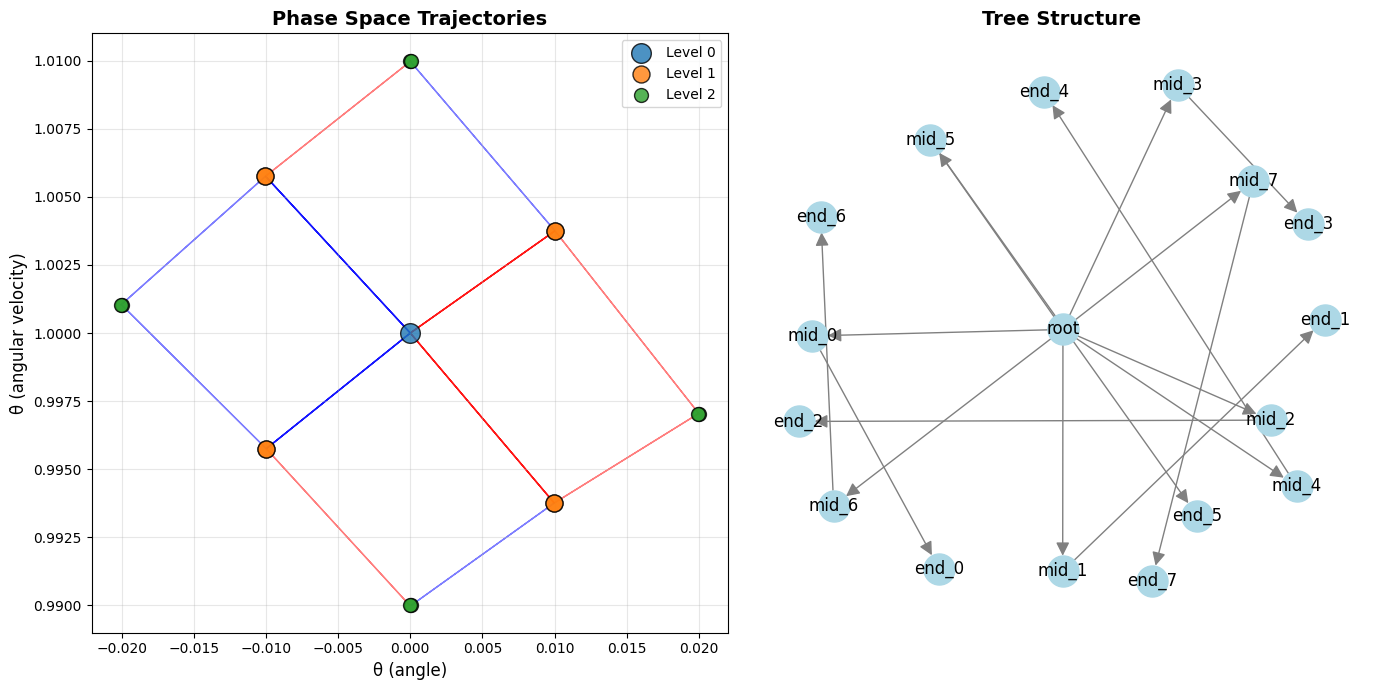

In [253]:
# Визуализация базового дерева
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Фазовое пространство
plot_phase_space(tree_data, ax1)

# Граф структуры
ax2.set_title('Tree Structure', fontsize=14, fontweight='bold')

# Создаем граф
graph = create_graph_from_tree_data(tree_data)

# Теперь можно использовать nx.spring_layout
pos = nx.spring_layout(graph, k=2, iterations=50)

nx.draw(graph, pos, ax=ax2,
        with_labels=True, node_size=500,
        node_color='lightblue', edge_color='gray',
        arrows=True, arrowsize=20)

plt.tight_layout()
plt.show()


In [9]:
0.02 * 0.001 / 2

1e-05

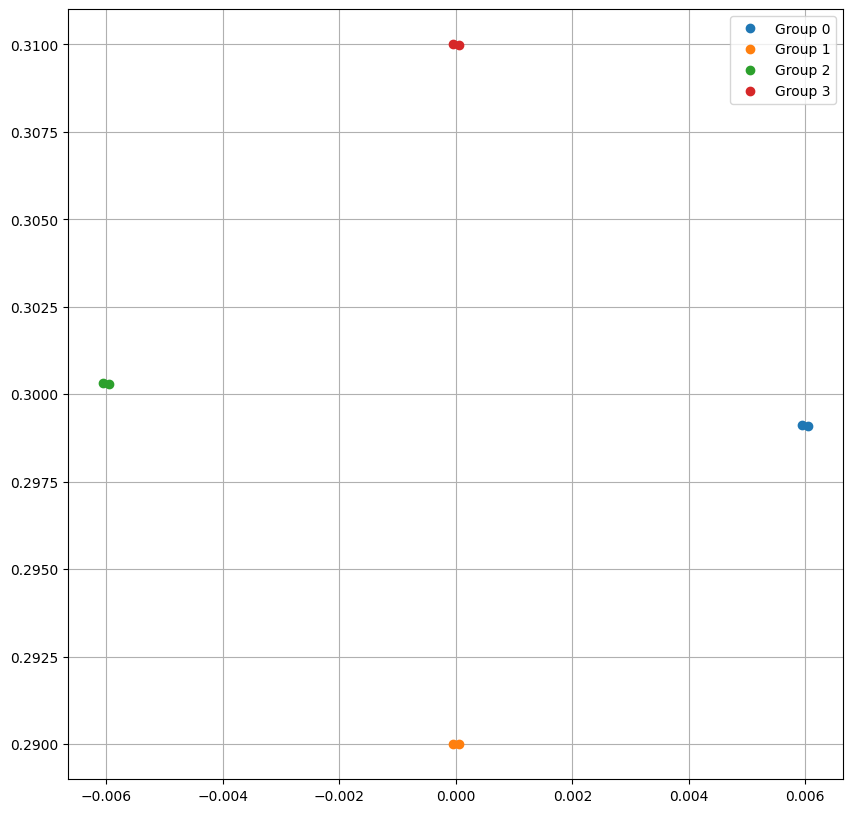

In [10]:
plt.figure(figsize=(10, 10))
deltas = []
weights = np.array([1, 1])
for i in range(4):
    end_points = tree_data['convergence_info']['groups'][i]['endpoints']
    delta_v = end_points[0] - end_points[1]
    delta_n = np.sqrt(delta_v**2 @ weights)
    # deltas.append(delta_n)
    # print(i)
    # print(end_points)
    # print(delta_v)
    # print(delta_v**2 @ weights)
    # print(delta_n)

    # if i in (0, 2):
    plt.plot(end_points[0][0], end_points[0][1], 'o', color=f'C{i}')
    plt.plot(end_points[1][0], end_points[1][1], 'o', color=f'C{i}', label=f'Group {i}')

plt.grid()
plt.legend()
# plt.axis('equal')

In [11]:
def correct_pair(end_points_lst):
    end_points_lst = np.array(end_points_lst)
    # print(end_points_lst)
    # print('-'*100)

    buf_1 = end_points_lst[::2].copy()
    buf_2 = buf_1.copy()

    buf_2[0, 1] = buf_1[1, 0]
    buf_2[1, 0] = buf_1[0, 1]

    distances = []

    for buf in (buf_1, buf_2):
        a = np.sqrt(((buf[0][0] - buf[0][1])**2).sum())
        b = np.sqrt(((buf[1][0] - buf[1][1])**2).sum())

        distances.append(a+b)
        # print(a)
        # print(b)
        # print(a+b)
        # print('-'*100)

    if distances[0] > distances[1]:
        buf = end_points_lst[0, 1].copy()
        end_points_lst[0, 1] = end_points_lst[2, 0].copy()
        end_points_lst[2, 0] = buf

    return end_points_lst

In [12]:
end_points_lst = [tree_data['convergence_info']['groups'][i]['endpoints'] for i in range(4)]
end_points_lst = correct_pair(end_points_lst)
end_points_lst

array([[[ 6.04197989e-03,  2.99099296e-01],
        [ 5.94210842e-03,  2.99114185e-01]],

       [[ 5.00146263e-05,  2.89995816e-01],
        [-4.99812946e-05,  2.90005815e-01]],

       [[-5.95400452e-03,  3.00303407e-01],
        [-6.05407595e-03,  3.00308507e-01]],

       [[-5.00146263e-05,  3.10004184e-01],
        [ 4.99812946e-05,  3.09994185e-01]]])

In [13]:
def calc_pair_distances(end_points_lst):
    ret = np.zeros(len(end_points_lst))
    for i in range(len(end_points_lst)):
        ret[i] = np.sqrt(((end_points_lst[i][0] - end_points_lst[i][1])**2).sum())
    return ret

In [14]:
calc_pair_distances(end_points_lst)

array([0.00010098, 0.00010049, 0.0001002 , 0.00010049])

In [15]:
def calculate_mean_points(end_points_lst):
    means = np.zeros(( len(end_points_lst), 2))
    for i in range(len(end_points_lst)):
        means[i] = (end_points_lst[i][0] + end_points_lst[i][1]) / 2

    return means

mean_points = calculate_mean_points(end_points_lst)
mean_points

array([[ 5.99204415e-03,  2.99106741e-01],
       [ 1.66658488e-08,  2.90000816e-01],
       [-6.00404024e-03,  3.00305957e-01],
       [-1.66658512e-08,  3.09999184e-01]])

In [16]:
def calculate_area(mean_points):
    # end_points - это список из 4-х 2D-координат
    # Используем формулу Шнура
    x = [p[0] for p in mean_points]
    y = [p[1] for p in mean_points]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    return area

calculate_area(mean_points)

0.00011995103734833572

In [17]:
(mean_points[0] - mean_points[2])[0]

0.01199608438963502

In [ ]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

time_intervals = np.ones(8) * 0.001

builder = ControlTreeBuilder(pendulum, dt_vector=time_intervals)
initial_position = np.array([0, 0.0125])
tree_data = builder.build_tree(initial_position)

end_points_lst = [tree_data['convergence_info']['groups'][i]['endpoints'] for i in range(4)]
end_points_lst = correct_pair(end_points_lst)

array([[[ 2.54973670e-05,  1.24973252e-02],
        [ 2.44974699e-05,  1.24974301e-02]],

       [[ 5.00016463e-07,  1.14999508e-02],
        [-4.99983129e-07,  1.15000508e-02]],

       [[-2.45023698e-05,  1.25023301e-02],
        [-2.55024670e-05,  1.25024252e-02]],

       [[-5.00016463e-07,  1.35000492e-02],
        [ 4.99983129e-07,  1.34999492e-02]]])

In [77]:
def calc_end_points(initial_position, time_intervals):
    pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

    builder = ControlTreeBuilder(pendulum, dt_vector=time_intervals)
    tree_data = builder.build_tree(initial_position)

    end_points_lst = [tree_data['convergence_info']['groups'][i]['endpoints'] for i in range(4)]
    end_points_lst = correct_pair(end_points_lst)

    return end_points_lst

In [83]:
def pre_objective(initial_position, time_intervals):
    end_points_lst = calc_end_points(initial_position, time_intervals)

    mean_points = calculate_mean_points(end_points_lst)

    area = calculate_area(mean_points)

    return -area    

objective = lambda initial_position: lambda time_intervals: pre_objective(initial_position, time_intervals)
objective(np.array([0, 0]))(np.ones(8) * 0.1)

-0.0009637275118930912

In [229]:
def pre_calc_constraint(initial_position, time_intervals, i, epsilon = 10**-5):
    end_points_lst = calc_end_points(initial_position, time_intervals)

    distances = calc_pair_distances(end_points_lst)

    return epsilon - distances[i]

calc_constraint = lambda initial_position: lambda i: lambda eps: lambda time_intervals: pre_calc_constraint(initial_position, time_intervals, i, eps)
calc_constraint(np.array([0, 0]))(3)(10**-5)(np.ones(8) * 0.1)

-0.009998545078161175

In [230]:
initial_position = np.array([0, 0])

constraints = [{'type': 'ineq', 'fun': calc_constraint(initial_position)(i)(10**-5)} for i in range(4)]
    
# constraints[3]['fun'](np.ones(8) * 0.001)
constraints

[{'type': 'ineq',
  'fun': <function __main__.<lambda>.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>(time_intervals)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>(time_intervals)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>(time_intervals)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>(time_intervals)>}]

In [162]:
def iteration_callback(xk):
    """
    Выводит на экран номер итерации и текущее значение переменных.
    'xk' - это текущее значение вектора решения (аналог вашего x0).
    """
    # Чтобы отслеживать номер итерации, можно использовать глобальную переменную
    # или атрибут функции.
    if not hasattr(iteration_callback, "iteration_counter"):
        iteration_callback.iteration_counter = 0
    else:
        iteration_callback.iteration_counter += 1
    
    # Чтобы не засорять вывод, можно выводить информацию, например,
    # каждую 10-ю итерацию
    if iteration_callback.iteration_counter % 10 == 0:
        print(f"Итерация: {iteration_callback.iteration_counter}, : {xk}")


In [239]:
def plot_end_points(initial_position, end_points):

    plt.plot(initial_position[0], initial_position[1], 'o', color='black')
    for i in range(4):
        plt.plot(end_points[i][0][0], end_points[i][0][1], 'o', color=f'C{i}')
        plt.plot(end_points[i][1][0], end_points[i][1][1], 'o', color=f'C{i}', label=f'Group {i}')

        # print(end_points[i])
        # print()

    plt.legend()
    plt.grid()

In [283]:
import numpy as np
from scipy.optimize import minimize

initial_position = np.array([0, 1])
initial_guess = np.ones(8) * 0.05
bounds = [(0, 0.05)] * 8
eps = 10**-3

constraints = [{'type': 'ineq', 'fun': calc_constraint(initial_position)(i)(eps)} for i in range(4)]

result = minimize(
    fun=objective(initial_position),
    x0=initial_guess,
    constraints=constraints,
    method='SLSQP',
    # callback=iteration_callback,
    bounds=bounds
    )
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.004888126286537432
       x: [ 5.000e-02  1.944e-02  1.999e-02  5.000e-02  1.995e-02
            5.000e-02  1.999e-02  5.000e-02]
     nit: 9
     jac: [-3.524e-02 -3.351e-02 -2.488e-02 -4.483e-02 -3.486e-02
           -3.556e-02 -4.500e-02 -2.470e-02]
    nfev: 81
    njev: 9

In [284]:

print(objective(initial_position)(result['x']))
print(objective(initial_position)(initial_guess))

-0.004888126286537432
-0.009898400082731082


[0.05    0.01944 0.01999 0.05    0.01995 0.05    0.01999 0.05   ]
-0.004888126286537432


<Axes: title={'center': 'Phase Space Trajectories'}, xlabel='θ (angle)', ylabel='θ̇ (angular velocity)'>

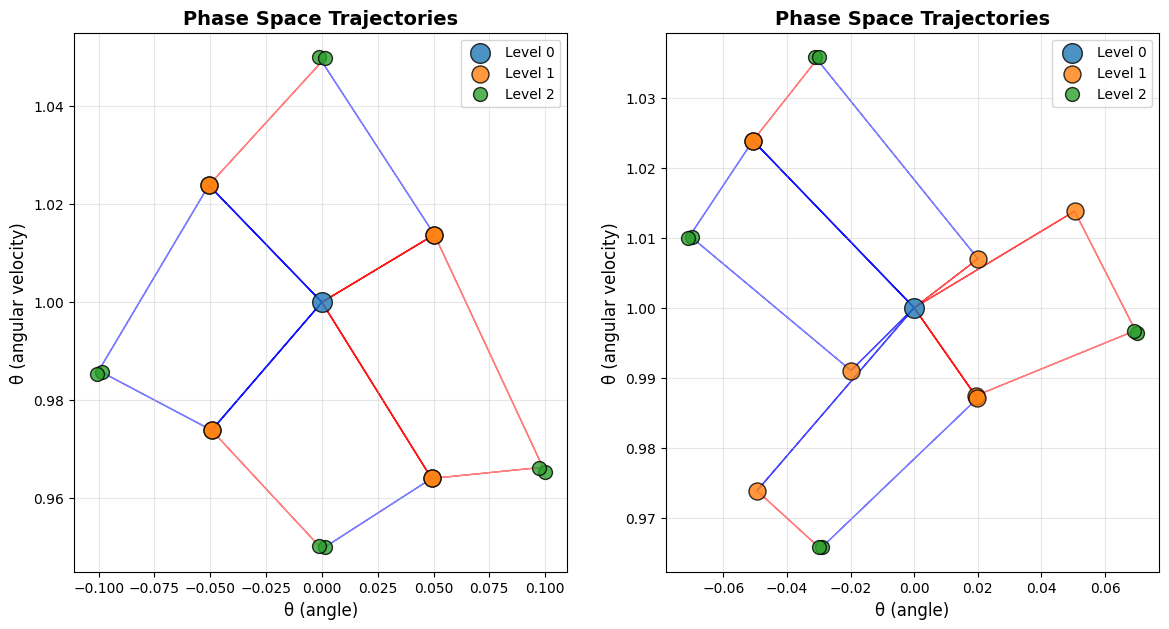

In [292]:

print(result['x'].round(5))
print(objective(initial_position)(result['x']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

plt.subplot(1, 2, 1)
builder = ControlTreeBuilder(pendulum, dt_vector=initial_guess)
initial_position = np.array([0, 1.0])
tree_data = builder.build_tree(initial_position)
plot_phase_space(tree_data, ax1)

plt.subplot(1, 2, 2)
builder = ControlTreeBuilder(pendulum, dt_vector=result['x'])
initial_position = np.array([0, 1.0])
tree_data = builder.build_tree(initial_position)
plot_phase_space(tree_data, ax2)



In [ ]:
def pre_objective(initial_position, time_intervals):
    end_points_lst = calc_end_points(initial_position, time_intervals)

    mean_points = calculate_mean_points(end_points_lst)

    area = calculate_area(mean_points)

    return -area    

objective = lambda initial_position: lambda time_intervals: pre_objective(initial_position, time_intervals)
objective(np.array([0, 0]))(np.ones(8) * 0.1)

-0.0009637275118930912

In [259]:
np.set_printoptions(suppress=True)